In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings("ignore")

## IMPORTING ALL THE REQUIRED PACKAGES


In [8]:
import os
import fnmatch
import random
import numpy as np
import pandas as pd
import statistics as st
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import tensorflow as tf
from keras.models import Sequential, model_from_yaml
from keras.layers import Dense, Dropout, Bidirectional, LSTM
from tensorflow.python.keras import regularizers
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers.rnn.lstm_v1 import LSTMCell
from keras import backend as K

## DATA PREPROCESSING

In [ ]:

#taking mode of 4 consecutive rows
def get_mode(X, y, time_step, step_size):
    X_values = []
    y_values = []
    for i in range(0, len(X) - time_step, step_size):
        value = X.iloc[i:(i + time_step)].values
        X_values.append(value)
        labels = y.iloc[i:(i + time_step)]
        y_values.append(stats.mode(labels)[0][0])
    return np.array(X_values), np.array(y_values).reshape(-1, 1)

def preprocess(f):

  train_path = "/content/drive/MyDrive/TrainingData/"        #loading training data
  df_X = pd.read_csv(train_path + f +"__x.csv")
  df_y = pd.read_csv(train_path + f +"__y.csv")
  
  labels = []

  for label in df_y.iterrows():
      labels += [label[1][0]] * 4
  
  df_y_labels = pd.DataFrame(labels)
  difference = df_X.shape[0] - df_y_labels.shape[0]
  df_X = df_X.iloc[:-difference,:]

  columns = list(df_X.columns.values)

  scaler = StandardScaler()
  scaler = scaler.fit(df_X[columns])
  df_X.loc[:, columns] = scaler.transform(df_X[columns].to_numpy())


  X, y = get_mode(df_X, df_y_labels, 30, 1)
  print(y.shape, X.shape)
  return X, y

In [ ]:

def train_test_val_split(train = False, val = False, test = False):


    train_path = "/content/drive/MyDrive/TrainingData/"
    trainingFile = os.listdir(train_path)
    files_x = fnmatch.filter(trainingFile, '*x.csv')
    files_x_time = fnmatch.filter(trainingFile, '*x_time.csv')
    files_y = fnmatch.filter(trainingFile, '*y.csv')
    files_y_time = fnmatch.filter(trainingFile, '*y_time.csv')
    files = sorted(set([x[:14] for x in files_x]))


    X_combined = []
    y_combined = []

    for f in files:

        if(train == True):
          if(f == "subject_002_01" or f == "subject_001_08" or f == "subject_006_03" or f == "subject_007_01"):
            continue
          X_temp, y_temp = preprocess(f)
          X_combined.append(X_temp)
          y_combined.append(y_temp)

        elif(val == True):
          if(f == "subject_002_01" or f == "subject_001_08"):
            X_temp, y_temp = preprocess(f)
            X_combined.append(X_temp)
            y_combined.append(y_temp)
        elif(test == True):
          if(f == "subject_006_03" or f == "subject_007_01"):
            X_temp, y_temp = preprocess(f)
            X_combined.append(X_temp)
            y_combined.append(y_temp)
    return np.concatenate(X_combined), np.concatenate(y_combined)


In [ ]:
X_train, y_train = train_test_val_split(train = True)
X_test, y_test = train_test_val_split(test = True)
X_val, y_val = train_test_val_split(val = True)

(37858, 1) (37858, 30, 6)
(70138, 1) (70138, 30, 6)
(43114, 1) (43114, 30, 6)
(54922, 1) (54922, 30, 6)
(59086, 1) (59086, 30, 6)
(38598, 1) (38598, 30, 6)
(31390, 1) (31390, 30, 6)
(55366, 1) (55366, 30, 6)
(48762, 1) (48762, 30, 6)
(51426, 1) (51426, 30, 6)
(42286, 1) (42286, 30, 6)
(36278, 1) (36278, 30, 6)
(47178, 1) (47178, 30, 6)
(19498, 1) (19498, 30, 6)
(34274, 1) (34274, 30, 6)
(34442, 1) (34442, 30, 6)
(56046, 1) (56046, 30, 6)
(34486, 1) (34486, 30, 6)
(44870, 1) (44870, 30, 6)
(48090, 1) (48090, 30, 6)
(59530, 1) (59530, 30, 6)
(46954, 1) (46954, 30, 6)
(44606, 1) (44606, 30, 6)
(39406, 1) (39406, 30, 6)
(48106, 1) (48106, 30, 6)
(45094, 1) (45094, 30, 6)
(46166, 1) (46166, 30, 6)
(66730, 1) (66730, 30, 6)
(55966, 1) (55966, 30, 6)


In [ ]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(1126710, 30, 6) (1126710, 1)
(122696, 30, 6) (122696, 1)
(91260, 30, 6) (91260, 1)


In [ ]:
label_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train.ravel())
label_weights = {i:label_weights[i] for i in range(len(label_weights))}
print(label_weights)

{0: 0.3258715475333822, 1: 5.860711164745537, 2: 4.427916810764926, 3: 1.8697229376310969}


In [ ]:
def encoder(labels):
    encoder = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
    encoder = encoder.fit(labels)
    training_y_encoded = encoder.transform(labels)
    return training_y_encoded

In [ ]:
y_train_encoded = encoder(y_train)
y_val_encoded = encoder(y_val)
y_test_encoded = encoder(y_test)
print(y_train_encoded.shape, y_val_encoded.shape, y_test_encoded.shape)

(1126710, 4) (122696, 4) (91260, 4)


## MODEL TRAINING

In [ ]:
#Evaluation metrics
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r)/(p + r + K.epsilon()))

#BiLSTM model

def bidirectional_lstm(X_train, y_train_encoded):
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_encoded.shape[1]
    model = Sequential()
    model.add(Bidirectional(LSTM(units = 125), input_shape = (n_timesteps, n_features)))
    model.add(Dropout(rate = 0.5))
    model.add(Dense(units = 125, activation = 'relu'))
    model.add(Dense(n_outputs, activation = 'softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc', f1, precision, recall])
    return model

In [ ]:
model = bidirectional_lstm(X_train, y_train_encoded)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 250)              132000    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 250)               0         
                                                                 
 dense_8 (Dense)             (None, 125)               31375     
                                                                 
 dense_9 (Dense)             (None, 4)                 504       
                                                                 
Total params: 163,879
Trainable params: 163,879
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train_encoded, epochs = 5, batch_size = 64, validation_data = (X_val, y_val_encoded), class_weight = label_weights, verbose = 1, shuffle = True)

Epoch 1/5
17605/17605 [==============================] - 2001s 113ms/step - loss: 0.1994 - acc: 0.8849 - f1: 0.8822 - precision: 0.8906 - recall: 0.8747 - val_loss: 1.3956 - val_acc: 0.6115 - val_f1: 0.6068 - val_precision: 0.6135 - val_recall: 0.6009
Epoch 2/5
17605/17605 [==============================] - 1886s 107ms/step - loss: 0.0988 - acc: 0.9377 - f1: 0.9374 - precision: 0.9398 - recall: 0.9350 - val_loss: 1.7085 - val_acc: 0.6259 - val_f1: 0.6238 - val_precision: 0.6266 - val_recall: 0.6211
Epoch 3/5
17605/17605 [==============================] - 1877s 107ms/step - loss: 0.0701 - acc: 0.9540 - f1: 0.9539 - precision: 0.9551 - recall: 0.9527 - val_loss: 1.9264 - val_acc: 0.6105 - val_f1: 0.6086 - val_precision: 0.6113 - val_recall: 0.6060
Epoch 4/5
17605/17605 [==============================] - 1889s 107ms/step - loss: 0.0539 - acc: 0.9641 - f1: 0.9641 - precision: 0.9647 - recall: 0.9634 - val_loss: 2.0262 - val_acc: 0.6386 - val_f1: 0.6368 - val_precision: 0.6390 - val_recall:

In [ ]:
model.save('model_epoch5.h5')     #saving model

## PLOTS and Model Evaluation




Loss Curve

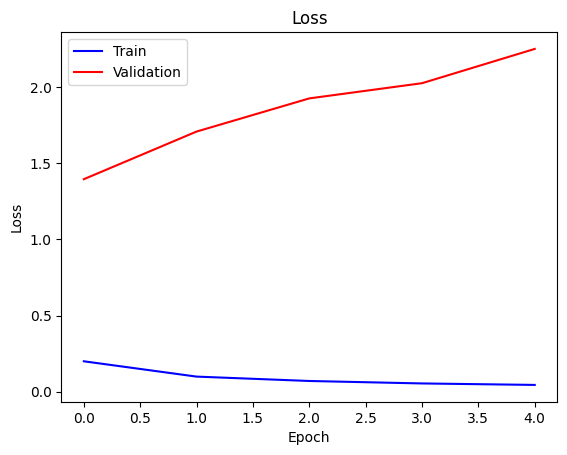

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='red', label='test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

Accuracy Curve

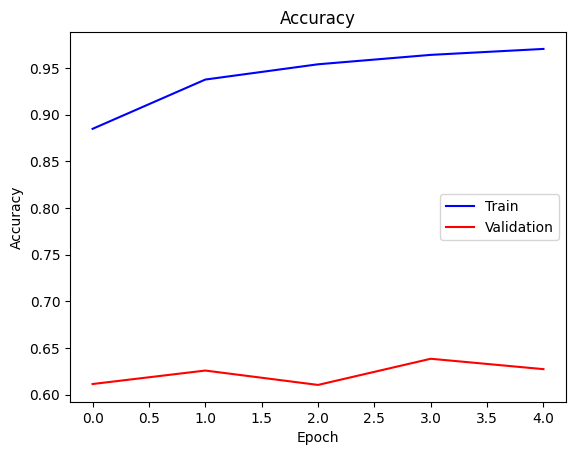

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['acc'], color='blue', label='train')
plt.plot(history.history['val_acc'], color='red', label='test')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

F1, Precision and Recall Curves

In [ ]:
plt.title('F1-Score')
plt.plot(history.history['f1'], color='blue', label='train')
plt.plot(history.history['val_f1'], color='red', label='test')
plt.ylabel('F1-Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

plt.title('Precision')
plt.plot(history.history['precision_measure'], color='blue', label='train')
plt.plot(history.history['val_precision_measure'], color='red', label='test')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

plt.title('Recall')
plt.plot(history.history['recall_measure'], color='blue', label='train')
plt.plot(history.history['val_recall_measure'], color='red', label='test')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()


In [ ]:
model.evaluate(X_test, y_test_encoded)

2852/2852 [==============================] - 72s 25ms/step - loss: 0.2396 - acc: 0.9303 - f1: 0.9300 - precision: 0.9306 - recall: 0.9295


[0.23957248032093048,
 0.9302761554718018,
 0.9300252199172974,
 0.930635392665863,
 0.9294793009757996]

In [ ]:
y_pred = model.predict(X_test, batch_size = 64, verbose = 1)
y_test_bool = np.argmax(y_pred, axis = 1)
print(classification_report(y_test, y_test_bool))

1426/1426 [==============================] - 63s 44ms/step
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     65623
           1       0.84      0.97      0.90      2892
           2       0.88      1.00      0.94      3745
           3       0.91      0.79      0.85     19000

    accuracy                           0.93     91260
   macro avg       0.89      0.93      0.91     91260
weighted avg       0.93      0.93      0.93     91260



## HIDDEN TEST DATASET

In [ ]:
#converting test data into format of training data
def test_preprocess(X, time_steps, step_size):
    X_values = []
    for i in range(0, len(X) - time_steps, step_size):
        value = X.iloc[i:(i + time_steps)].values
        X_values.append(value)        
    return np.array(X_values)

def get_mode(output):
    output_actual = []
    for i in range(0, output.shape[0], 4):
        lst = list(output[i:i + 4])
        output_actual.append(stats.mode(lst)[0])
    return np.array(output_actual)


In [ ]:
#loading test files
test_files = ['TestData/subject_009_01__x.csv', 'TestData/subject_010_01__x.csv', 
              'TestData/subject_011_01__x.csv', 'TestData/subject_012_01__x.csv']

y_files = ['TestData/subject_009_01__y_time.csv', 'TestData/subject_010_01__y_time.csv',
           'TestData/subject_011_01__y_time.csv', 'TestData/subject_012_01__y_time.csv']

prediction_files = ['subject_009_01__y_prediction.csv', 'subject_010_01__y_prediction.csv',
                    'subject_011_01__y_prediction.csv', 'subject_012_01__y_prediction.csv']

In [ ]:
#Predicting for test files
for i in range(len(test_files)):
    input_data = pd.read_csv(test_files[i])
    columns = list(input_data.columns.values)

    scaler = StandardScaler()
    scaler = scaler.fit(input_data[columns])
    input_data.loc[:, columns] = scaler.transform(input_data[columns].to_numpy())


    y_frame = pd.read_csv(y_files[i])
    addl = y_frame.shape[0] * 4 - df.shape[0] + 30
    addl_df = pd.DataFrame(input_data.iloc[-addl:])
    df = input_data.append(addl_df)
    X_test = test_preprocess(df, 30, 1)
    y_test = model.predict(X_test, batch_size = 64, verbose = 1)
    y_test_bool = np.argmax(y_test, axis = 1)
    y_actual = get_mode(y_test_bool)
    y_actual = y_actual.reshape(-1)
    y_series = pd.Series(y_actual)
    y_series.to_csv("./Final_Result/" + prediction_files[i], index = False)